# Notebook I: Training the Centroid Estimation CNN

This notebook is about estimating instance (building) centroids. Here we design and train a neural network that detect centroids of instances (buildings) from input RGB images (satellite images).

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Designing the Neural Network
    3) Training and Prediction
    
__Dataset citation__: *SpaceNet on Amazon Web Services (AWS). “Datasets.” The SpaceNet Catalog. Last modified October 1st, 2018. https://spacenet.ai/datasets/*

<hr>
<hr>
<hr>

In [2]:
'''first importing libraries'''

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout
from keras import backend as K

import cv2

import glob
from random import shuffle
import numpy as np
from matplotlib import pyplot as plt
import imageio

import tensorflow as tf

### 1) Reading and Exploring Data

First, let's read __*tiles_satellite_images*__ and __*tiles_building_centroids*__ data (including training and test datasets). 

In [ ]:
'''Loading datasets'''

x_read = np.load('./data/tiles_satellite_images.npz')
y_read = np.load('./data/tiles_building_centroids.npz')

x_train = x_read['x_train'].astype(float)
x_test = x_read['x_test'].astype(float)
y_train = y_read['y_train'].astype(float)
y_test = y_read['y_test'].astype(float)

In [3]:
print(x_train.shape) # shape corresponding to: [Image tiles, Height, Width, R/G/B]
print(y_train.shape) # shape corresponding to: [Image tiles, Height, Width, Binary (building Centroid or Not)]

(1236, 256, 256, 3)
(1236, 32, 32, 1)


In [4]:
print(x_test.shape) # shape corresponding to: [Image tiles, Height, Width, R/G/B]
print(y_test.shape) # shape corresponding to: [Image tiles, Height, Width, Binary (building Centroid or Not)]

(648, 256, 256, 3)
(648, 32, 32, 1)


__*tiles_satellite_images*__ data contains RGB satellite image tiles. Each tile's shape is (256, 256) pixels. And __*tiles_building_centroids*__ data contains centroids of buildings in each tile (if the pixel is a building centroid, pixel value is 1 and 0 otherwise).

When satellite images are processed through the centroid estimation CNN, dimensions of the images will be reduced due to max-pooling operations in the network. Hence, __*tiles_building_centroids*__ data contains centroids of buildings at (32, 32) image size/scale.

Let's visualize random impute and output image to see how it looks,

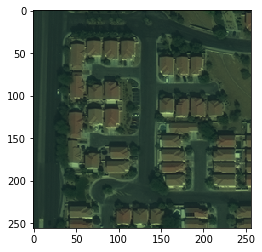

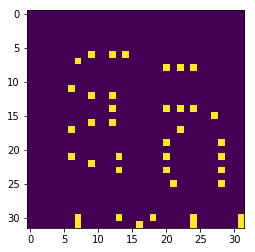

[0. 1.]


In [5]:
'''plot sample of training data'''

rand_idx = np.random.randint(0,y_test.shape[0]) # generation random index to choose random sample

plt.imshow(x_test[rand_idx,:,:,:])
plt.show()

plt.imshow(y_test[rand_idx,:,:,0])
plt.show()

print(np.unique(y_train[25,:,:,0])) # printing unique values of centroid tiles to make sure

### 2) Designing the Neural Network

It's a typical CNN with Convolutional layers, Max pooling operations and Dropouts.

In [8]:
x_in = Input(shape=(None, None, 3)) # input shape: (height, width, 3 bands of RGB)

x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions

x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='relu', padding='same')(x_temp) # single unit because of single band output

# custom loss function to calculation weighted RMSE
def customLoss(yTrue, yPred):
    return K.sqrt(K.sum(K.flatten( K.tf.multiply(K.square(yTrue - yPred), yTrue+1)/(1*2+1) ))/(32*32))

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss=customLoss, optimizer=keras.optimizers.Adam()) # setting loss and optimizer

model.summary() # printing the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
__________

Other than usual layers in a CNN, in the middle of the network, dilated convolutions were used (*dilation_rate=(2, 2)*). If we add too many max pooling layers, final image size will be too smaller and building centroids will be merged. To avoid this and to increase receptive field of the CNN, we are using dilated convolutions in the centroid estimation CNN. Dilated convolutions allow an increase in receptive field size without losing spatial resolution.

Since number of centroid points are very low compared to non-centroid points, there is a class imbalanced issue. To overcome this, we have used weighted Root Mean Squared Error (RMSE) loss function (0.66 weight on loss of centroids pixels and 0.33 weight on loss of non-centroids pixels).

### 3) Training and Prediction

In [ ]:
'''training the model'''

batch_size = 50
epochs = 100

fit_h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=1, validation_data=(x_test,y_test))

*Note: set verbose=1 to see training progress for each epoch. Single epoch takes 6s in single NVIDIA GTX 1080 Ti GPU.*

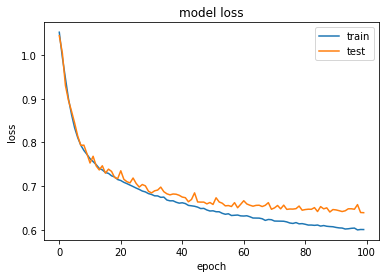

In [10]:
'''plotting loss curves'''

plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
'''saving the model'''

model_json = model.to_json()
with open("./models/Centroid_Estimation.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("./models/Centroid_Estimation.h5")

In [12]:
'''prediction over the training/test dataset from the trained model '''

yp_train = model.predict(x_train, batch_size=batch_size)
print(yp_train.shape);

yp_test = model.predict(x_test, batch_size=batch_size)
print(yp_test.shape);

(1236, 32, 32, 1)
(648, 32, 32, 1)


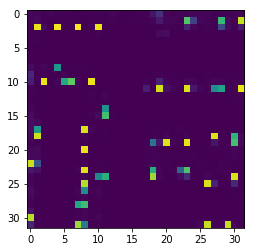

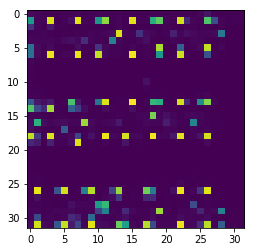

In [13]:
'''plot couple of predictions to see how it comes'''

plt.imshow(yp_train[181,:,:,0], vmin=0, vmax=1)
plt.show()

plt.imshow(yp_test[181,:,:,0], vmin=0, vmax=1)
plt.show()